In [1]:
import datetime
import os
import random
from itertools import repeat
from pathlib import Path

import holidays
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from faker import Faker
from scipy.stats import expon, gamma, norm, randint, skewnorm, uniform
from unidecode import unidecode_expect_ascii

In [2]:
# constants
shop_open_date = datetime.datetime(2021, 6, 1) # Dzień Dziecka bo tak
today = datetime.datetime(2023, 6, 30)
staff_number = 6
tournament_number = 20
customers_number = 1500

# Faza 1 - przygotowanie

1. wszystkie stałe, liczby itp do słownika `config` i odwołania w funkcjach
2. funkcje maja być bezargumentowe
3. polenglish
4. jest wywołanie tych funkcji wszystkich w jednej komórce

```python
sales = jakiś dataframe
sales = ogranij_cos_z_sales()

```

In [ ]:
def ogranij_cos_z_sales():
    return sales.reindex()

# to jest niby funkcja
sales = 213123
sales = ogranij_cos_z_sales()



## Wczytanie csv

In [3]:
def file_path(file_name: str):
    dir_path = [i for i in Path.cwd().parents if i.name == "geeks-and-dragons-db"][0]
    path = os.path.join(dir_path, "config", "prompts", file_name)
    if os.path.exists(path):
        return path
    else:
        raise FileNotFoundError("No such file")

In [4]:
prompt_games = pd.read_csv(file_path("gry.csv"))
prompt_first_names_males = pd.read_csv(file_path("imiona_m.csv"))
prompt_last_names_males = pd.read_csv(file_path("nazwiska_m.csv"))
prompt_first_names_females = pd.read_csv(file_path("imiona_k.csv"))
prompt_last_names_females = pd.read_csv(file_path("nazwiska_k.csv"))
prompt_cities = pd.read_csv(file_path("miasta.csv"))
prompt_emails = pd.read_csv(file_path("Domeny.csv"))
prompt_tournaments = pd.read_csv(file_path("turnieje.csv"), delimiter=";")

## Tabela prompt_dates

In [5]:
weekday_dict = {
    "0": "Poniedziałek",
    "1": "Wtorek",
    "2": "Środa",
    "3": "Czwartek",
    "4": "Piątek",
    "5": "Sobota",
}


def gen_dates(start_date, end_date):
    dates = []
    holidays_pl = holidays.Poland()
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() != 6 and current_date not in holidays_pl:
            dates.append(
                (
                    current_date.date().strftime("%d-%m-%Y"),
                    weekday_dict[str(current_date.weekday())],
                )
            )
        current_date += datetime.timedelta(days=1)
    return dates

In [6]:
generated_dates = gen_dates(shop_open_date, today)

In [7]:
prompt_dates = pd.DataFrame(generated_dates, columns=["Data", "Dzień tygodnia"])
prompt_dates["Data"] = pd.to_datetime(prompt_dates["Data"], format="%d-%m-%Y")
prompt_dates["Data"]

0     2021-06-01
1     2021-06-02
2     2021-06-04
3     2021-06-05
4     2021-06-07
         ...    
629   2023-06-26
630   2023-06-27
631   2023-06-28
632   2023-06-29
633   2023-06-30
Name: Data, Length: 634, dtype: datetime64[ns]

## Ruch - dni

In [8]:
initial_customer_n = 12
daily_customer_increment = 0.02
dodatek_dzienny_mnoznik = 1
dodatek_dzienny = {
    "Poniedziałek": 2,
    "Wtorek": 1,
    "Środa": 0,
    "Czwartek": 4,
    "Piątek": 5,
    "Sobota": 5,
}

volume_base = []
for i in range(len(prompt_dates["Dzień tygodnia"])):
    dd = dodatek_dzienny[prompt_dates["Dzień tygodnia"][i]]
    volume_base.append(
        round(
            initial_customer_n
            + daily_customer_increment * i
            + dd * dodatek_dzienny_mnoznik
        )
    )

In [9]:
prompt_dates["volume_base"] = volume_base

In [10]:
volume_sales = []
for v_base in prompt_dates["volume_base"]:
    szum = round(norm.rvs(0, 1.5))
    volume_sales.append(max(0, v_base + szum))

prompt_dates["volume_sales"] = volume_sales

In [11]:
volume_rental = []
for v_base in prompt_dates["volume_base"]:
    szum = round(norm.rvs(0, 1.5))
    volume_rental.append(max(0, round(0.4 * v_base + szum)))

prompt_dates["volume_rental"] = volume_rental

In [12]:
prompt_dates.head()

,Data,Dzień tygodnia,volume_base,volume_sales,volume_rental
0,2021-06-01,Wtorek,23,25,8
1,2021-06-02,Środa,20,18,11
2,2021-06-04,Piątek,35,36,14
3,2021-06-05,Sobota,35,34,14
4,2021-06-07,Poniedziałek,26,25,8


## Tabela procentowa z godzinami

In [13]:
hours = []
for i in range(8, 20):
    if i < 18:
        hours.append((i, round(expon.rvs(i / 2))))
    else:
        hours.append((i, round(expon.cdf(i / 3))))

In [14]:
hours_prompt = pd.DataFrame(hours, columns=["Godzina", "Ilość klientów"])

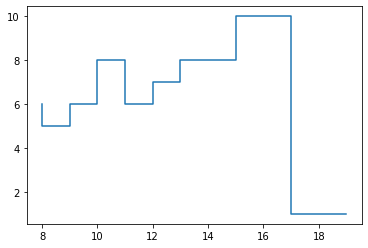

In [15]:
plt.step(range(8, 20), hours_prompt["Ilość klientów"])

In [16]:
hours_prompt["Natężenie"] = [
    hours_prompt["Ilość klientów"][i] / sum(hours_prompt["Ilość klientów"])
    for i in range(len(hours_prompt["Godzina"]))
]

In [17]:
sum(hours_prompt["Natężenie"])

1.0

## Gry

In [18]:
prompt_games[1:] = prompt_games[1:].sample(frac=1)

In [19]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN
1,K2,planszowa,stretegiczna,"K2 to rodzinna gra planszowa, w której uczestn...",TAK,119.90,NaN,5.0
2,Munchkin,karciana,towarzyska,"Munchkin to niekolekcjonerska gra karciana, kt...",TAK,44.90,11.0,5.0
3,Władca Pierścieni Podróże Przez Śródziemie,planszowa,strategiczna,Wyrusz w Podróże przez Śródziemie z grą Władca...,NIE,315.95,NaN,NaN
4,Splendor,karciana,towarzyska,Wciel się w renesansowego kupca i rozpocznij s...,NIE,121.91,17.0,NaN


In [20]:
wagi = expon.pdf(x=np.linspace(0, 2, len(prompt_games["Nazwa"])), loc=-1 / 9)
prompt_games["wagi"] = [wagi[i] / np.sum(wagi) for i in range(len(wagi))]

In [21]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników,wagi
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN,0.045967
1,K2,planszowa,stretegiczna,"K2 to rodzinna gra planszowa, w której uczestn...",TAK,119.90,NaN,5.0,0.044128
2,Munchkin,karciana,towarzyska,"Munchkin to niekolekcjonerska gra karciana, kt...",TAK,44.90,11.0,5.0,0.042363
3,Władca Pierścieni Podróże Przez Śródziemie,planszowa,strategiczna,Wyrusz w Podróże przez Śródziemie z grą Władca...,NIE,315.95,NaN,NaN,0.040669
4,Splendor,karciana,towarzyska,Wciel się w renesansowego kupca i rozpocznij s...,NIE,121.91,17.0,NaN,0.039043


_______________

# Faza 2 - tabele pomocnicze

## Pracownicy

In [22]:
id_generator = lambda n: [*range(1, n + 1)]


gender_generator = lambda n: random.choices(["M", "F"], weights=[0.5, 0.5], k=n)


def phone_generator(n):
    WST = [45, 50, 51, 53, 57, 60, 66, 69, 72, 73, 78, 79, 88]
    digit = [i for i in range(10)]
    phone_numbers = []
    while n > 0:
        phone = "".join(map(str, [random.choice(WST), *random.choices(digit, k=7)]))
        if phone not in phone_numbers:
            phone_numbers.append(phone)
            n -= 1
        else:
            pass
    return phone_numbers


def first_name_generator(df):
    gender_list = df["gender"]
    names = []
    for gender in gender_list:
        if gender == "M":
            names.append(
                *random.choices(
                    prompt_first_names_males["imię"],
                    weights=prompt_first_names_males["prob"],
                )
            )
        elif gender == "F":
            names.append(
                *random.choices(
                    prompt_first_names_females["imię"],
                    weights=prompt_first_names_females["prob"],
                )
            )
    return names


def last_name_generator(df):
    gender_list = df["gender"]
    last_names = []
    for gender in gender_list:
        if gender == "M":
            last_names.append(
                *random.choices(
                    prompt_last_names_males["nazwisko"],
                    weights=prompt_last_names_males["prob"],
                )
            )
        elif gender == "F":
            last_names.append(
                *random.choices(
                    prompt_last_names_females["nazwisko"],
                    weights=prompt_last_names_females["prob"],
                )
            )
    return last_names


def email_generator(df):
    name = (
        df["first_name"]
        .str.cat(df["last_name"], sep=".")
        .apply(lambda x: unidecode_expect_ascii(x))
    )
    while name.is_unique == False:
        name = name.apply(lambda x: x + str(random.choice(range(10))))
    df["email"] = name.apply(
        lambda x: "@".join([x, random.choice(prompt_emails["Domena"])])
    )


def to_date_generator(n):
    dates = [np.nan for i in range(n)]
    dates[n - 2] = Faker().date_between(
        shop_open_date + datetime.timedelta(days=90),
        today - datetime.timedelta(days=90),
    )
    return dates


def from_date_generator(df):
    n = df.shape[0]
    end_date = df["to_date"].loc[df["to_date"].isnull() == False].values[0]
    dates = [shop_open_date for i in range(n)]
    dates[n - 1] = end_date + datetime.timedelta(days=30)
    return dates


def staff_update_generator(df):
    n = df.shape[0]
    df_date = df[["to_date", "from_date"]]
    df["updated_at"] = df_date.max(axis=1, skipna=True, numeric_only=False).apply(
        lambda x: x
        + pd.DateOffset(
            hours=random.choice(range(8, 20)),
            minutes=random.choice(range(0, 60)),
            seconds=random.choice(range(0, 60)),
        )
    )


def salary_generator(df):
    n = df.shape[0]
    df["current_salary"] = [
        round(3490 + expon.rvs(scale=100, loc=80), 2) for i in range(n)
    ]
    df.loc[df["to_date"].isnull() == False, "current_salary"] = np.nan


def is_manager(df):
    n = df.shape[0]
    df["is_manager"] = [False for i in range(n)]
    df.loc[df["current_salary"] == df["current_salary"].max(), "is_manager"] = True

In [23]:
def staff_df_generator(n):
    staff = pd.DataFrame(
        {
            "gender": [*gender_generator(n)],
            "phone": [*phone_generator(n)],
            "to_date": [*to_date_generator(n)],
        }
    )
    staff["city"] = np.full((1, staff.shape[0]), "Wrocław")[0]
    staff["from_date"] = from_date_generator(staff)
    staff["first_name"] = first_name_generator(staff)
    staff["last_name"] = last_name_generator(staff)
    email_generator(staff)
    salary_generator(staff)
    is_manager(staff)
    staff_update_generator(staff)
    staff.sort_values(by=["updated_at"], inplace=True)
    staff["staff_id"] = id_generator(n)
    staff = staff.reindex(
        labels=[
            "staff_id",
            "first_name",
            "last_name",
            "phone",
            "email",
            "city",
            "current_salary",
            "is_manager",
            "gender",
            "from_date",
            "to_date",
            "updated_at",
        ],
        axis=1,
    )
    return staff

In [24]:
staff = staff_df_generator(staff_number)
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
1,1,ALEKSANDER,PIWOWARCZYK,574760221,ALEKSANDER.PIWOWARCZYK@yahoo.com,Wrocław,3674.00,False,M,2021-06-01,NaN,2021-06-01 11:16:03
0,2,JAN,BARTCZAK,665325317,JAN.BARTCZAK@gmail.com,Wrocław,3573.35,False,M,2021-06-01,NaN,2021-06-01 11:21:17
3,3,ALIAKSANDR,JANUSZEWSKI,606133782,ALIAKSANDR.JANUSZEWSKI@polska.pl,Wrocław,3722.76,False,M,2021-06-01,NaN,2021-06-01 16:50:06
2,4,MIRELLA,LASEK,698181748,MIRELLA.LASEK@poczta.pl,Wrocław,3643.96,False,F,2021-06-01,NaN,2021-06-01 18:17:47
4,5,EWA,MAREK,518919196,EWA.MAREK@neostrada.pl,Wrocław,NaN,False,F,2021-06-01,2022-11-04,2022-11-04 12:50:06
5,6,BARBARA,GOŁAŚ,663522155,BARBARA.GOLAS@vp.pl,Wrocław,3805.89,True,F,2022-12-04,NaN,2022-12-04 19:59:44


## Godziny pracy

In [25]:
def weekday_hour_worker_generator():
    hours = range(8, 20)
    weekdays = ["Poniedziałek", "Wtorek", "Środa", "Czwartek", "Piątek", "Sobota"]

    w = []
    h = []
    for i in hours:
        for j in weekdays:
            w.append(j)
            h.append(i)
    wk = []
    for i in h:
        if i < 14:
            wk.append((1, 2))
        else:
            wk.append((3, 4, 6))

    weekday_hour_worker = pd.DataFrame({"weekdays": w, "hour": h, "staff": wk})
    return weekday_hour_worker

In [26]:
weekday_hour_worker = weekday_hour_worker_generator()
weekday_hour_worker.head()

,weekdays,hour,staff
0,Poniedziałek,8,"(1, 2)"
1,Wtorek,8,"(1, 2)"
2,Środa,8,"(1, 2)"
3,Czwartek,8,"(1, 2)"
4,Piątek,8,"(1, 2)"


## Związki

In [27]:
# losowanie wektora z rozkładu normalnego z warunkiem na wartość minimalną
def norm_with_condition_generator(n, loc, scale, condition):
    dates = norm.rvs(scale=scale, loc=loc, size=n)
    mask = dates > condition
    while mask.all() == False:
        dates = norm.rvs(scale=scale, loc=loc, size=n)
        mask = dates > condition
    return dates.round().astype(int)

In [28]:
N = int(np.ceil(staff_number * 1.5))


def realtionships_df_generator(staff_df, n=N):
    staff_id = []
    staff_gender = []
    update = []
    staff_df = staff_df.loc[staff_df["current_salary"].isnull() == False]
    for i in range(n):
        employee = random.choices(
            staff_df.staff_id.values, weights=staff_df.current_salary.values
        )
        staff_id.append(*employee)
        staff_gender.append(
            *staff_df["gender"].loc[staff_df.staff_id == employee[0]].values
        )
        update.append(
            Faker().date_between_dates(
                pd.to_datetime(
                    staff_df.from_date.loc[staff_df.staff_id == employee[0]].values[0]
                ),
                today,
            )
            + pd.DateOffset(
                hours=random.choice(range(8, 20)),
                minutes=random.choice(range(0, 60)),
                seconds=random.choice(range(0, 60)),
            )
        )
    df = pd.DataFrame(
        {
            "staff_id": staff_id,
            "staff_gender": staff_gender,
            "dates_number": norm_with_condition_generator(n, 5, 2, 0),
            "updated_at": update,
        }
    )
    df.sort_values(by=["updated_at"], inplace=True)
    df["relationship_id"] = id_generator(df.shape[0])
    df["partner_id"] = id_generator(df.shape[0])
    df = df.reindex(
        labels=[
            "relationship_id",
            "staff_id",
            "staff_gender",
            "partner_id",
            "dates_number",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [29]:
relationships = realtionships_df_generator(staff)
relationships

,relationship_id,staff_id,staff_gender,partner_id,dates_number,updated_at
5,1,2,M,1,3,2021-06-30 11:52:17
6,2,2,M,2,4,2021-11-06 18:55:02
3,3,1,M,3,5,2022-02-05 16:59:45
2,4,1,M,4,4,2022-02-27 12:08:24
0,5,4,F,5,5,2022-03-02 17:27:13
1,6,1,M,6,6,2022-03-23 11:50:10
4,7,1,M,7,4,2022-10-04 11:37:52
8,8,1,M,8,4,2022-11-11 15:10:23
7,9,6,F,9,2,2022-12-22 08:20:10


## Partnerzy

In [30]:
def partners_df_generator(relationships_df):
    partner = relationships_df.partner_id
    staff_gender = relationships_df.staff_gender.values
    gender = []
    for el in staff_gender:
        if el == "M":
            gender.append(random.choices(["M", "F"], weights=[0.1, 0.9])[0])
        elif el == "F":
            gender.append(random.choices(["M", "F"], weights=[0.9, 0.1])[0])

    partners = pd.DataFrame(
        {
            "partner_id": partner,
            "gender": gender,
            "updated_at": relationships_df.updated_at,
        }
    )
    partners["name"] = first_name_generator(partners)
    partners.sort_values(by=["updated_at"], inplace=True)
    partners = partners.reindex(
        labels=["partner_id", "name", "gender", "updated_at"], axis=1
    )
    return partners

In [31]:
partners = partners_df_generator(relationships)
partners

,partner_id,name,gender,updated_at
5,1,JUSTYNA,F,2021-06-30 11:52:17
6,2,HALINA,F,2021-11-06 18:55:02
3,3,MAŁGORZATA,F,2022-02-05 16:59:45
2,4,ANETA,F,2022-02-27 12:08:24
0,5,MAREK,M,2022-03-02 17:27:13
1,6,LESIA,F,2022-03-23 11:50:10
4,7,TERESA,F,2022-10-04 11:37:52
8,8,DANUTA,F,2022-11-11 15:10:23
7,9,GRZEGORZ,M,2022-12-22 08:20:10


## Klienci - część A

In [32]:
customers = pd.DataFrame({"customer_id": id_generator(customers_number)})

## Koszty utrzymania

In [33]:
def expenses_dates_generator(day=5):
    base = pd.DataFrame(
        prompt_dates.loc[
            (prompt_dates["Data"].dt.day == day)
            | (prompt_dates["Data"].dt.day == day + 1),
            "Data",
        ]
    )
    base["flag"] = base["Data"].dt.to_period("M")
    base.drop_duplicates(["flag"], keep="first", inplace=True)
    base = base.reset_index()
    return base["Data"]

In [34]:
def rent_generator():
    date_df = prompt_dates.loc[prompt_dates["Data"].dt.day == 5, "Data"]
    title = date_df.dt.month_name(locale="pl_PL").apply(
        lambda x: "CZYNSZ " + str(x).upper()
    )
    df = pd.DataFrame(
        {
            "date": date_df,
            "title": title,
            "amount": np.full((1, date_df.shape[0]), 3250)[0],
            "type": np.full((1, date_df.shape[0]), "CZYNSZ")[0],
        }
    )
    return df


def energy_generator():
    date_df = prompt_dates.loc[prompt_dates["Data"].dt.day == 5, "Data"]
    title = date_df.dt.month_name(locale="pl_PL").apply(
        lambda x: "ENERGIA ELEKTRYCZNA " + str(x).upper()
    )
    df = pd.DataFrame(
        {
            "date": date_df,
            "title": title,
            "amount": [
                max(round(norm.rvs(150, 4), 2), 100) for i in range(date_df.shape[0])
            ],
            "type": np.full((1, date_df.shape[0]), "MEDIA")[0],
        }
    )
    return df


def water_generator():
    date_df = prompt_dates.loc[prompt_dates["Data"].dt.day == 5, "Data"]
    title = date_df.dt.month_name(locale="pl_PL").apply(
        lambda x: "WODA " + str(x).upper()
    )
    df = pd.DataFrame(
        {
            "date": date_df,
            "title": title,
            "amount": [
                max(round(norm.rvs(50, 2), 2), 15) for i in range(date_df.shape[0])
            ],
            "type": np.full((1, date_df.shape[0]), "MEDIA")[0],
        }
    )
    return df


def heat_generator():
    dates = []
    date_df = prompt_dates.loc[prompt_dates["Data"].dt.day == 5, "Data"]
    for j in range(2021, 2024):
        for i in range(4, 11):
            day = datetime.datetime(j, i, 5)
            dates.append(day.strftime("%Y-%m-%d"))
    for i in dates:
        date_df = date_df.drop(date_df[date_df == i].index)
    title = date_df.dt.month_name(locale="pl_PL").apply(
        lambda x: "OGRZEWANIE " + str(x).upper()
    )
    df = pd.DataFrame(
        {
            "date": date_df,
            "title": title,
            "amount": [round(norm.rvs(100, 4), 2) for i in range(date_df.shape[0])],
            "type": np.full((1, date_df.shape[0]), "MEDIA")[0],
        }
    )
    return df


def salary_generator(staff_df):
    date_df = expenses_dates_generator(10)
    all_staff = pd.concat(
        [staff_df[["first_name", "last_name", "current_salary"]]] * date_df.shape[0],
        ignore_index=True,
    )
    staff_name = staff_df["first_name"].str.cat(staff_df["last_name"], sep=" ")
    names = pd.concat([staff_name] * date_df.shape[0], ignore_index=True)
    dates = np.repeat(date_df, staff_name.shape[0])
    dates = dates.reset_index()["Data"]
    title_first = dates.dt.month_name(locale="pl_PL").apply(
        lambda x: "PENSJA " + str(x).upper()
    )
    title = title_first.str.cat(names, sep=" ")
    df = pd.DataFrame(
        {
            "date": dates,
            "title": title,
            "amount": all_staff["current_salary"],
            "type": np.full((1, title.shape[0]), "PENSJA")[0],
        }
    )
    to_date = pd.to_datetime(
        staff_df["to_date"].loc[staff_df["to_date"].isnull() == False].values[0]
    )
    df.loc[(df["amount"].isnull() == True) & (df["date"] < to_date), "amount"] = round(
        3490 + expon.rvs(scale=100, loc=80), 2
    )
    df.dropna(inplace=True)
    return df


def maintenance_expenses_df_generator():
    df = pd.DataFrame(
        {"date": [], "title": [], "amount": [], "type": [], "updated_at": []}
    )
    df = pd.concat(
        [
            df,
            rent_generator(),
            energy_generator(),
            water_generator(),
            heat_generator(),
            salary_generator(staff),
        ]
    )
    df["updated_at"] = df["date"].apply(
        lambda x: x
        + pd.DateOffset(
            hours=random.choice(range(8, 20)),
            minutes=random.choice(range(0, 60)),
            seconds=random.choice(range(0, 60)),
        )
    )
    df.sort_values(by=["updated_at"], inplace=True)
    df["payment_id"] = id_generator(df.shape[0])
    df["invoice_id"] = id_generator(df.shape[0])
    df["spend_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "spend_id",
            "title",
            "amount",
            "type",
            "date",
            "payment_id",
            "invoice_id",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [35]:
maintenance_expenses = maintenance_expenses_df_generator()
maintenance_expenses

,spend_id,title,amount,type,date,payment_id,invoice_id,updated_at
3,1,ENERGIA ELEKTRYCZNA CZERWIEC,143.83,MEDIA,2021-06-05,1,1,2021-06-05 08:07:24
3,2,WODA CZERWIEC,49.47,MEDIA,2021-06-05,2,2,2021-06-05 11:53:13
3,3,CZYNSZ CZERWIEC,3250.00,CZYNSZ,2021-06-05,3,3,2021-06-05 14:09:46
0,4,PENSJA CZERWIEC ALEKSANDER PIWOWARCZYK,3674.00,PENSJA,2021-06-10,4,4,2021-06-10 08:52:34
3,5,PENSJA CZERWIEC MIRELLA LASEK,3643.96,PENSJA,2021-06-10,5,5,2021-06-10 15:23:25
...,...,...,...,...,...,...,...,...
145,205,PENSJA CZERWIEC JAN BARTCZAK,3573.35,PENSJA,2023-06-10,205,205,2023-06-10 12:45:22
146,206,PENSJA CZERWIEC ALIAKSANDR JANUSZEWSKI,3722.76,PENSJA,2023-06-10,206,206,2023-06-10 13:17:34
149,207,PENSJA CZERWIEC BARBARA GOŁAŚ,3805.89,PENSJA,2023-06-10,207,207,2023-06-10 17:21:18
147,208,PENSJA CZERWIEC MIRELLA LASEK,3643.96,PENSJA,2023-06-10,208,208,2023-06-10 19:13:39


## Typy wydatków

In [36]:
def expense_types_df_generator(expense_df):
    df = pd.DataFrame(
        {"expenses_type": expense_df["type"], "updated_at": expense_df["updated_at"]}
    )
    df.drop_duplicates(subset=["expenses_type"], keep="last", inplace=True)
    df.sort_values(by=["updated_at"], inplace=True)
    df["expenses_type_id"] = id_generator(df.shape[0])
    df = df.reindex(["expenses_type_id", "expenses_type", "updated_at"], axis=1)
    return df

In [37]:
expense_types = expense_types_df_generator(maintenance_expenses)
expense_types

,expenses_type_id,expenses_type,updated_at
612,1,CZYNSZ,2023-06-05 11:42:23
612,2,MEDIA,2023-06-05 15:15:35
144,3,PENSJA,2023-06-10 19:35:47


## Tytuły wydatków

In [38]:
def expense_titles_df_generator(expense_df, expense_types_df):
    df = pd.DataFrame(
        {
            "title": expense_df["title"],
            "expenses_type": expense_df["type"],
            "updated_at": expense_df["updated_at"],
        }
    )
    df.drop_duplicates(subset=["title"], keep="last", inplace=True)
    df = pd.merge(
        df,
        expense_types_df[["expenses_type_id", "expenses_type"]],
        how="left",
        on=["expenses_type"],
    )
    df.sort_values(by=["updated_at"], inplace=True)
    df["title_id"] = id_generator(df.shape[0])
    df = df.reindex(["title_id", "title", "expenses_type_id", "updated_at"], axis=1)
    return df

In [39]:
expense_titles = expense_titles_df_generator(maintenance_expenses, expense_types)
expense_titles.head()

,title_id,title,expenses_type_id,updated_at
0,1,PENSJA LISTOPAD EWA MAREK,3,2021-11-10 14:41:14
1,2,PENSJA GRUDZIEŃ EWA MAREK,3,2021-12-10 16:00:19
2,3,PENSJA STYCZEŃ EWA MAREK,3,2022-01-10 18:04:35
3,4,CZYNSZ LUTY,1,2022-02-05 08:28:59
4,5,OGRZEWANIE LUTY,2,2022-02-05 12:21:04


## Wydatki i tytuły jeszcze raz

In [40]:
maintenance_expenses2 = pd.merge(
    maintenance_expenses, expense_titles[["title_id", "title"]], how="left", on="title"
)
maintenance_expenses2.sort_values(by=["updated_at"], inplace=True)
maintenance_expenses2 = maintenance_expenses2.reindex(
    [
        "spend_id",
        "title_id",
        "type",
        "amount",
        "payment_id",
        "invoice_id",
        "updated_at",
    ],
    axis=1,
)

In [41]:
maintenance_expenses2.head()

,spend_id,title_id,type,amount,payment_id,invoice_id,updated_at
0,1,107,MEDIA,143.83,1,1,2021-06-05 08:07:24
1,2,108,MEDIA,49.47,2,2,2021-06-05 11:53:13
2,3,106,CZYNSZ,3250.00,3,3,2021-06-05 14:09:46
3,4,113,PENSJA,3674.00,4,4,2021-06-10 08:52:34
4,5,112,PENSJA,3643.96,5,5,2021-06-10 15:23:25


## Turnieje

In [42]:
def game_tournament_generator():
    games = prompt_games.loc[
        prompt_games["Turniej"] == "TAK", ["Nazwa", "rodzaj", "kategoria"]
    ]
    tournament_games = pd.merge(
        games,
        prompt_tournaments,
        left_on=["rodzaj", "kategoria"],
        right_on=["Rodzaj", "Kategoria"],
        suffixes=["_gry", "_turnieju"],
    )
    tournament_games = tournament_games[["Nazwa_gry", "Nazwa_turnieju"]]
    return tournament_games


def tournament_staff_generator():
    staff = weekday_hour_worker.loc[
        (weekday_hour_worker["weekdays"] == "Piątek")
        & (weekday_hour_worker["hour"] >= 15)
    ]["staff"].sample(1, replace=True)
    return random.choice(staff.values[0])


def count_matches(x):
    suma = 0
    while x >= 0:
        suma += 2 ** x
        x -= 1
    return suma

In [43]:
def tournaments_df_generator():
    dates = pd.DataFrame(
        prompt_dates.loc[prompt_dates["Dzień tygodnia"] == "Piątek", "Data"].iloc[::6]
    ).reset_index()["Data"]
    n = dates.shape[0]
    tournament = game_tournament_generator()
    tournament = tournament.sample(
        n, replace=False, ignore_index=True
    )  # nie może być ten sam wiersz
    tree_levels_number = randint.rvs(2, 4, size=n)
    matches = map(lambda x: count_matches(x), tree_levels_number)
    df = pd.DataFrame(
        {
            "name": tournament["Nazwa_turnieju"],
            "game": tournament["Nazwa_gry"],
            "start_time": dates + datetime.timedelta(hours=15),
            "matches": matches,
            "tree_levels": tree_levels_number,
            "fee": np.full((1, n), 50)[0],
            "sign_up_deadline": dates
            - datetime.timedelta(days=3)
            + datetime.timedelta(hours=20),
            "staff_id": [tournament_staff_generator() for i in range(n)],
            "expenses": map(
                lambda x: round(x, 2), gamma.rvs(a=1.5, loc=200, scale=20, size=n)
            ),
            "updated_at": dates.apply(
                lambda x: x
                + datetime.timedelta(
                    hours=15,
                    minutes=random.randint(1, 5),
                    seconds=random.randint(1, 59),
                )
            ),
        }
    )
    df.sort_values(by=["updated_at"], inplace=True)
    df["tournament_id"] = id_generator(n)
    df["invoice_id"] = id_generator(n)
    df = df.reindex(
        [
            "tournament_id",
            "name",
            "game",
            "start_time",
            "matches",
            "tree_levels",
            "fee",
            "sign_up_deadline",
            "staff_id",
            "expenses",
            "invoice_id",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [44]:
tournaments = tournaments_df_generator()
tournaments.head()

,tournament_id,name,game,start_time,matches,tree_levels,fee,sign_up_deadline,staff_id,expenses,invoice_id,updated_at
0,1,Krucjata Karcianych Mistrzów,Tajniacy,2021-06-04 15:00:00,7,2,50,2021-06-01 20:00:00,3,274.80,1,2021-06-04 15:02:35
1,2,Cytadela Strategii,Scythe,2021-07-16 15:00:00,15,3,50,2021-07-13 20:00:00,6,270.32,2,2021-07-16 15:01:09
2,3,Wrocławski Konwent Planszówkowy,Catan: Osadnicy z Catanu,2021-08-27 15:00:00,7,2,50,2021-08-24 20:00:00,3,238.08,3,2021-08-27 15:02:55
3,4,Wrocławski Festiwal Gier Planszowych,Monopoly Classic,2021-10-08 15:00:00,15,3,50,2021-10-05 20:00:00,4,214.30,4,2021-10-08 15:02:32
4,5,Krucjata Karcianych Mistrzów,UNO,2021-11-19 15:00:00,15,3,50,2021-11-16 20:00:00,6,225.82,5,2021-11-19 15:01:26


## Udziały

In [45]:
def sign_up_date_generator(deadline):
    deadline = pd.to_datetime(deadline)
    date = pd.to_datetime(
        prompt_dates["Data"]
        .loc[
            (prompt_dates["Data"] < deadline)
            & (prompt_dates["Data"] > deadline - pd.DateOffset(days=14))
        ]
        .sample(1, ignore_index=True)
        .values[0]
    )
    date += pd.DateOffset(
        hours=random.choice(range(8, 20)),
        minutes=random.choice(range(0, 60)),
        seconds=random.choice(range(0, 60)),
    )
    return date

In [46]:
def participations_df_generator(tournament_df, customers_df):
    # liczba uczestników
    players = pd.merge(
        tournament_df[
            ["game", "tree_levels", "tournament_id", "fee", "sign_up_deadline"]
        ],
        prompt_games[["Nazwa", "Liczba uczestników"]],
        left_on=["game"],
        right_on=["Nazwa"],
        how="left",
    )
    players["Liczba uczestników"] = players["Liczba uczestników"].astype("int")
    players_number = players["Liczba uczestników"] * (2 ** players["tree_levels"])
    players["players"] = players_number

    # customer_id i miejsce
    participants = map(
        lambda x: customers_df["customer_id"]
        .sample(x, replace=False, ignore_index=True)
        .values,
        players_number,
    )
    players["place"] = players["players"].apply(lambda x: [*range(1, x + 1)])
    players["customer_id"] = list(participants)

    # ostateczny df
    df = players[["tournament_id", "customer_id", "fee", "sign_up_deadline", "place"]]
    df = df.explode(["customer_id", "place"], ignore_index=True)
    df["sign_up_date"] = df["sign_up_deadline"].apply(
        lambda x: sign_up_date_generator(x)
    )
    df["updated_at"] = df["sign_up_date"].copy()
    df.sort_values(by=["updated_at"], inplace=True)
    df["particip_id"] = id_generator(df.shape[0])
    df["invoice_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "particip_id",
            "tournament_id",
            "customer_id",
            "place",
            "sign_up_date",
            "fee",
            "invoice_id",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [47]:
participations = participations_df_generator(tournaments, customers)
participations.head()

,particip_id,tournament_id,customer_id,place,sign_up_date,fee,invoice_id,updated_at
23,1,1,911,24,2021-06-01 08:19:18,50,1,2021-06-01 08:19:18
30,2,1,225,31,2021-06-01 09:04:50,50,2,2021-06-01 09:04:50
24,3,1,704,25,2021-06-01 09:05:48,50,3,2021-06-01 09:05:48
3,4,1,861,4,2021-06-01 10:30:12,50,4,2021-06-01 10:30:12
12,5,1,1159,13,2021-06-01 11:21:26,50,5,2021-06-01 11:21:26


## Magazyn

In [48]:
bulk_ratio = 0.5

In [49]:
def get_value_from_another_column(df, search_column, search_value, target_column):
    matching_rows = df.loc[df[search_column] == search_value]
    target_value = matching_rows[target_column].values[0]
    return target_value


def sell():
    N = sum(prompt_dates["volume_sales"]) * expon.rvs(loc=1 / 4)
    while N < 2500 or N > 3700:
        N = sum(prompt_dates["volume_sales"]) * expon.rvs(loc=1 / 4)
    ilość = list(map(round, prompt_games["wagi"] * N))
    M = [
        prompt_games["Nazwa"][i : i + 5]
        for i in range(0, len(prompt_games["Nazwa"]), 5)
    ]
    daty = []
    datysklepowe = list(prompt_dates["Data"].dt.strftime("%Y-%m-%d"))
    ilość2 = [sum(ilość[i : i + 5]) for i in range(0, 51, 5)]
    for i in range(len(M)):
        d = max(len(M) + round(norm.rvs(0, 5)), 1)
        day = datetime.datetime(
            random.choice(range(2021, 2024)), random.choice(range(1, 13)), d
        ).strftime("%Y-%m-%d")
        while day not in datysklepowe:
            day = datetime.datetime(
                random.choice(range(2021, 2024)), random.choice(range(1, 13)), d
            ).strftime("%Y-%m-%d")
        daty.append(day)
    index = [x for x, y in zip(range(1, len(M) + 1), ilość2) for _ in range(y)]
    indexy = [x for x, y in zip(index, ilość2) for _ in range(y)]
    daty_dost = [x for x, y in zip(daty, ilość2) for _ in range(y)]
    game = [x for x, y in zip(prompt_games["Nazwa"], ilość) for _ in range(y)]
    upd = [
        datetime.datetime.strptime(i, "%Y-%m-%d").replace(
            hour=random.randint(8, 19),
            minute=random.randint(0, 59),
            second=random.randint(0, 59),
        )
        for i in daty_dost
    ]
    ceny = [x for x, y in zip(prompt_games["Kupno"], ilość2) for _ in range(y)]
    df = pd.DataFrame(
        {
            "game": game,
            "destination": ["S" for _ in range(len(indexy))],
            "price": ceny,
            "active": [True for i in range(len(upd))],
            "purchase_payment": [round(bulk_ratio * cena, 2) for cena in ceny],
            "delivery_date": upd,
            "updated_at": upd,
        }
    )
    return df


def rental():
    N = 70
    games_r = [random.choice(prompt_games["Nazwa"]) for i in range(N)]
    daty = ["2021-06-01" for _ in range(N)]
    daty_upd = [
        datetime.datetime.strptime(i, "%Y-%m-%d").replace(
            hour=random.randint(8, 19),
            minute=random.randint(0, 59),
            second=random.randint(0, 59),
        )
        for i in daty
    ]
    df = pd.DataFrame(
        {
            "game": games_r,
            "destination": ["R" for _ in range(N)],
            "price": [
                round(
                    0.1
                    * get_value_from_another_column(
                        prompt_games, "Nazwa", gra, "Kupno"
                    ),
                    2,
                )
                for gra in games_r
            ],
            "active": [True for i in range(N)],
            "purchase_payment": [
                round(
                    bulk_ratio
                    * get_value_from_another_column(
                        prompt_games, "Nazwa", gra, "Kupno"
                    ),
                    2,
                )
                for gra in games_r
            ],
            "delivery_date": daty_upd,
            "updated_at": daty_upd,
        }
    )
    return df


def games_for_tournament(tournaments_df):
    games_amount = (
        tournaments_df[["game", "tree_levels"]]
        .groupby("game")
        .max()
        .apply(lambda x: 2 ** x)
    )
    games = pd.merge(games_amount, prompt_games, left_on=["game"], right_on=["Nazwa"])[
        ["tree_levels", "Nazwa", "Kupno"]
    ]
    n = games.shape[0]
    dates = ["2021-06-01" for _ in range(n)]
    updated = [
        datetime.datetime.strptime(i, "%Y-%m-%d").replace(
            hour=random.randint(8, 19),
            minute=random.randint(0, 59),
            second=random.randint(0, 59),
        )
        for i in dates
    ]
    df = pd.DataFrame(
        {
            "game": games["Nazwa"],
            "destination": ["T" for _ in range(n)],
            "price": [np.nan for i in range(n)],
            "active": [True for i in range(n)],
            "purchase_payment": games["Kupno"],
            "delivery_date": updated,
            "updated_at": updated,
        }
    )
    return df


def inventory_df_generator(tournaments_df):
    sell_df = sell()
    rental_df = rental()
    tournament_df = games_for_tournament(tournaments_df)
    df = pd.concat([sell_df, rental_df, tournament_df])
    df.sort_values(by=["updated_at"], inplace=True)
    df["inventory_id"] = id_generator(df.shape[0])
    df["invoice_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "inventory_id",
            "game",
            "destination",
            "price",
            "active",
            "purchase_payment",
            "invoice_id",
            "delivery_date",
            "updated_at",
        ],
        axis=1,
    )
    df = df.reset_index(drop=True)
    return df

In [50]:
inventory = inventory_df_generator(tournaments)
inventory.head()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



## Ceny gier

In [ ]:
def game_prices_df_generator(inventory_df):
    df = inventory_df.drop_duplicates(subset=["price"], keep="last", ignore_index=True)[
        ["price", "updated_at"]
    ]
    df.rename(columns={"price": "current_price"}, inplace=True)
    df = df.sort_values(["updated_at"])
    df["price_id"] = id_generator(df.shape[0])
    df = df.reindex(["price_id", "current_price", "updated_at"], axis=1)
    return df

In [ ]:
game_prices = game_prices_df_generator(inventory)
game_prices.head()

## Sprzedaże

In [ ]:
def sales_df_generator(inventory_df):
    all_date = []
    price = []
    invoice = []
    staff = []
    inventory = []
    for j in range(prompt_dates["Data"].shape[0]):
        for i in range(prompt_dates["volume_sales"][j]):
            hour = random.choices(
                hours_prompt["Godzina"], weights=hours_prompt["Natężenie"], k=1
            )[0]
            date = prompt_dates["Data"][j] + datetime.timedelta(
                hours=int(hour),
                minutes=random.randint(0, 59),
                seconds=random.randint(0, 59),
            )
            P = random.choices([1, 2, 3], weights=[0.7, 0.25, 0.05])[0]
            games = random.choices(
                prompt_games["Nazwa"], weights=prompt_games["wagi"], k=P
            )
            available_staff = weekday_hour_worker.loc[
                (weekday_hour_worker["weekdays"] == date.day_name(locale="pl_PL"))
                & (weekday_hour_worker["hour"] == date.hour)
            ]["staff"].sample(1, replace=True)
            staff_id = random.choice(available_staff.values[0])
            for k in games:
                mask = (
                    (inventory_df["game"] == k)
                    & (inventory_df["delivery_date"] < date)
                    & (inventory_df["destination"] == "S")
                    & (inventory_df["active"] == True)
                )
                if mask.any():
                    inventory_df.loc[mask.idxmax(), "active"] = False
                    price.append(inventory_df["price"].loc[mask.idxmax()])
                    all_date.append(date)
                    invoice.append(f"{i}_{j}")
                    staff.append(staff_id)
                    inventory.append(inventory_df["inventory_id"].loc[mask.idxmax()])

    df = pd.DataFrame(
        {
            "inventory_id": inventory,
            "price": price,
            "invoice": invoice,
            "staff_id": staff,
            "date": all_date,
            "return_oper": np.full((1, len(staff)), "False")[0],
            "updated_at": all_date,
        }
    )
    df.sort_values("updated_at", inplace=True)
    df["sale_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "sale_id",
            "inventory_id",
            "staff_id",
            "price",
            "date",
            "invoice",
            "return_oper",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [ ]:
sales = sales_df_generator(inventory)

In [ ]:
sales.head()

## Rentale

In [ ]:
def rental_df_generator(inventory_df):
    rental_date = []
    return_date = []
    customer = []
    price = []
    staff = []
    inventory = []
    rate = []
    update = []
    penalty = []
    invoice = []
    penalty_invoice = []
    for j in range(prompt_dates["Data"].shape[0]):
        for i in range(prompt_dates["volume_rental"][j]):
            hour = random.choices(
                hours_prompt["Godzina"], weights=hours_prompt["Natężenie"], k=1
            )[0]
            date = prompt_dates["Data"][j] + datetime.timedelta(
                hours=int(hour),
                minutes=random.randint(0, 59),
                seconds=random.randint(0, 59),
            )
            P = random.choices([1, 2], weights=[0.7, 0.3])[0]
            games = random.choices(
                prompt_games["Nazwa"], weights=prompt_games["wagi"], k=P
            )
            available_staff = weekday_hour_worker.loc[
                (weekday_hour_worker["weekdays"] == date.day_name(locale="pl_PL"))
                & (weekday_hour_worker["hour"] == date.hour)
            ]["staff"].sample(1, replace=True)
            staff_id = random.choice(available_staff.values[0])
            holding_time = gamma.rvs(scale=3, a=2)
            return_date_t = prompt_dates["Data"][j] + datetime.timedelta(
                days=int(holding_time),
                hours=round(abs(holding_time) % 1 * 24, 2),
                minutes=random.randint(0, 59),
                seconds=random.randint(0, 59),
            )
            for k in games:
                mask = (
                    (inventory_df["game"] == k)
                    & (inventory_df["delivery_date"] < date)
                    & (inventory_df["destination"] == "S")
                    & (inventory_df["active"] == True)
                )
                if mask.any():
                    customer.append(int(random.choice(customers["customer_id"])))
                    price.append(inventory_df["price"].loc[mask.idxmax()])
                    rental_date.append(date)
                    staff.append(staff_id)
                    inventory.append(inventory_df["inventory_id"].loc[mask.idxmax()])
                    invoice.append(f"{i}{j}")
                    if return_date_t > datetime.datetime.today():
                        return_date.append(np.nan)
                        update.append(date)
                        inventory_df.loc[mask.idxmax(), "active"] = False
                        penalty.append(np.nan)
                        penalty_invoice.append(np.nan)
                    else:
                        return_date.append(return_date_t)
                        update.append(return_date_t)
                        delta = return_date_t - date
                        if delta.days > 3:
                            penalty.append(
                                0.3
                                * get_value_from_another_column(
                                    prompt_games, "Nazwa", k, "Wypożyczenie"
                                )
                                * delta.days
                            )
                            penalty_invoice.append(f"P{i}_{j}")
                        else:
                            penalty.append(np.nan)
                            penalty_invoice.append(np.nan)
                    rate.append(random.randint(1, 10))

    df = pd.DataFrame(
        {
            "inventory_id": inventory,
            "customer_id": customer,
            "rental_date": rental_date,
            "return_date": return_date,
            "staff_id": staff,
            "price": price,
            "invoice": invoice,
            "penalty_payment": penalty,
            "penalty_invoice": penalty_invoice,
            "rate": rate,
            "updated_at": update,
        }
    )
    df.sort_values("updated_at", inplace=True)
    df["rental_id"] = id_generator(df.shape[0])
    df = df.reindex(
        [
            "rental_id",
            "inventory_id",
            "customer_id",
            "rental_date",
            "return_date",
            "staff_id",
            "price",
            "invoice",
            "penalty_payment",
            "penalty_invoice",
            "rate",
            "updated_at",
        ],
        axis=1,
    )
    return df

In [ ]:
rentals = rental_df_generator(inventory)
rentals.head()

## Gry

In [ ]:
def games_df_generator(inventory_df):
    update = inventory_df[["game", "delivery_date"]].groupby(["game"]).min()
    games = pd.merge(prompt_games, update, left_on=["Nazwa"], right_on=["game"])
    games = games[["Nazwa", "opis", "kategoria", "rodzaj", "Turniej", "delivery_date"]]
    games.rename(
        columns={
            "Nazwa": "title",
            "opis": "description",
            "kategoria": "category",
            "rodzaj": "type",
            "Turniej": "competitivity",
            "delivery_date": "updated_at",
        },
        inplace=True,
    )
    games["competitivity"] = games["competitivity"].apply(
        lambda x: True if x == "TAK" else False
    )
    games.sort_values(["updated_at"], inplace=True)
    games["game_id"] = id_generator(games.shape[0])
    games = games.reindex(
        [
            "game_id",
            "title",
            "description",
            "category",
            "type",
            "competitivity",
            "updated_at",
        ],
        axis=1,
    )
    return games

In [ ]:
games = games_df_generator(inventory)
games.head()

## Katrgorie gier i typy gier

In [ ]:
def game_categories_df_generator(games_df):
    df = games_df[["category", "updated_at"]].drop_duplicates("category", keep="first")
    df.rename(columns={"category": "game_category"}, inplace=True)
    df["category_id"] = id_generator(df.shape[0])
    df = df.reindex(["category_id", "game_category", "updated_at"], axis=1)
    return df

In [ ]:
game_categories = game_categories_df_generator(games)
game_categories

In [ ]:
games["category"] = games["category"].map(
    dict(zip(game_categories["game_category"], game_categories["category_id"]))
)

--------

In [ ]:
def game_types_df_generator(games_df):
    df = games_df[["type", "updated_at"]].drop_duplicates("type", keep="first")
    df.rename(columns={"type": "game_type"}, inplace=True)
    df["type_id"] = id_generator(df.shape[0])
    df = df.reindex(["type_id", "game_type", "updated_at"], axis=1)
    return df

In [ ]:
game_types = game_types_df_generator(games)
game_types

In [ ]:
games["type"] = games["type"].map(
    dict(zip(game_types["game_type"], game_types["type_id"]))
)

## Klienci - część B

In [ ]:
def customers_drop(customers, rentals, participations):
    for i in customers["customer_id"]:
        if (
            i not in rentals["customer_id"].values
            and i not in participations["customer_id"].values
        ):
            customers = customers.drop(customers[customers["customer_id"] == i].index)
    return customers

In [ ]:
customers = customers_drop(customers, rentals, participations)
customers

In [ ]:
merged_df = pd.concat([participations, rentals])

In [ ]:
rentals

In [ ]:
merged_df["updated_at"] = pd.to_datetime(merged_df["updated_at"])
merged_df = merged_df.groupby("customer_id")["updated_at"].min().reset_index()
customers["updated_at"] = list(merged_df["updated_at"])
customers.sort_values(["updated_at"], inplace=True)
temp = dict(zip(customers["customer_id"], id_generator(len(customers["customer_id"]))))
customers["customer_id"] = id_generator(len(customers["customer_id"]))
rentals["customer_id"] = rentals["customer_id"].map(temp)
participations["customer_id"] = participations["customer_id"].map(temp)

In [ ]:
prompt_cities

In [ ]:
def customers_df_generator(customers):
    n = len(customers["customer_id"])
    customers["gender"] = [*gender_generator(n)]
    customers["phone"] = [*phone_generator(n)]
    customers["city"] = [
        random.choices(prompt_cities["miasto"], weights=prompt_cities["prob"])[0]
        for i in range(n)
    ]
    customers["first_name"] = first_name_generator(customers)
    customers["last_name"] = last_name_generator(customers)
    email_generator(customers)
    customers = customers[
        [
            "customer_id",
            "first_name",
            "last_name",
            "phone",
            "email",
            "city",
            "updated_at",
        ]
    ]
    return customers

In [ ]:
customers = customers_df_generator(customers)
customers

## Miasta

In [ ]:
def cities():
    merged_df = pd.concat([customers, staff])
    merged_df.sort_values(["updated_at"], inplace=True)
    merged_df.drop_duplicates(subset=["city"], keep="first", inplace=True)
    city = pd.DataFrame(
        {
            "city_id": id_generator(len(merged_df["city"])),
            "city": merged_df["city"],
            "updated_at": merged_df["updated_at"],
        }
    )
    return city

In [ ]:
city = cities()
city

In [ ]:
temp = dict(zip(city["city"], city["city_id"]))
customers["city"] = customers["city"].map(temp)
staff["city"] = staff["city"].map(temp)
customers.rename(columns={"city": "city_id"})
staff.rename(columns={"city": "city_id"})

In [ ]:
staff

## Payments i invoices

In [ ]:
def working_payments_df_generator(
    inventory_df,
    sales_df,
    rentals_df,
    maintenance_expenses_df,
    tournaments_df,
    participations_df,
):
    # inventory
    df_inv = inventory_df[["purchase_payment", "invoice_id", "updated_at"]].rename(
        columns={
            "purchase_payment": "amount",
            "invoice_id": "invoice",
            "updated_at": "date",
        }
    )
    df_inv["invoice"] = "I" + df_inv["invoice"].astype(str)
    df_inv["amount"] = df_inv["amount"] * (-1)
    # sales
    df_sales = sales_df[["price", "invoice", "date"]].rename(
        columns={"price": "amount"}
    )
    df_sales["invoice"] = "S" + df_sales["invoice"].astype(str)
    # rent
    df_rent = rentals_df[["price", "invoice", "rental_date"]].rename(
        columns={"price": "amount", "rental_date": "date"}
    )
    df_rent["invoice"] = "R" + df_rent["invoice"].astype(str)
    # rent penalty
    df_rent_penalty = (
        rentals_df[["penalty_payment", "penalty_invoice", "return_date"]]
        .dropna()
        .rename(
            columns={
                "penalty_payment": "amount",
                "penalty_invoice": "invoice",
                "return_date": "date",
            }
        )
    )
    df_rent_penalty["invoice"] = "R" + df_rent_penalty["invoice"].astype(str)
    # expenses
    df_exp = maintenance_expenses_df[["amount", "invoice_id", "updated_at"]].rename(
        columns={"updated_at": "date", "invoice_id": "invoice"}
    )
    df_exp["invoice"] = "ME" + df_exp["invoice"].astype(str)
    df_exp["amount"] = df_exp["amount"] * (-1)
    # tour
    df_tour = tournaments_df[["expenses", "invoice_id", "updated_at"]].rename(
        columns={"expenses": "amount", "invoice_id": "invoice", "updated_at": "date"}
    )
    df_tour["invoice"] = "T" + df_tour["invoice"].astype(str)
    df_tour["amount"] = df_tour["amount"] * (-1)
    # participations
    df_part = participations_df[["fee", "invoice_id", "updated_at"]].rename(
        columns={"fee": "amount", "invoice_id": "invoice", "updated_at": "date"}
    )
    df_part["invoice"] = "P" + df_part["invoice"].astype(str)
    df = pd.concat(
        [df_inv, df_sales, df_rent, df_rent_penalty, df_exp, df_tour, df_part],
        ignore_index=True,
    )
    return df

In [ ]:
working_payments = working_payments_df_generator(
    inventory, sales, rentals, maintenance_expenses, tournaments, participations
)
working_payments.head()

In [ ]:
def invoices_df_generator(working_payments_df):
    df = working_payments_df[["invoice", "date"]]
    df = df.drop_duplicates("invoice")
    df["updated_at"] = df.loc[:, "date"]
    df["invoice_id"] = id_generator(df.shape[0])
    df = df.reindex(["invoice_id", "invoice", "date", "updated_at"], axis=1)
    return df

In [ ]:
invoices = invoices_df_generator(working_payments)
invoices.head()

In [ ]:
def payments_df_generator(working_payments_df, invoices_df):
    df = pd.merge(working_payments_df, invoices_df, on="invoice")[
        ["amount", "invoice_id", "updated_at"]
    ]
    df["payment_id"] = id_generator(df.shape[0])
    df = df.reindex(["payment_id", "amount", "invoice_id", "updated_at"], axis=1)
    return df.reset_index(drop=True)

In [ ]:
payments = payments_df_generator(working_payments, invoices)
payments.head()

------

# Faza 3 - ostateczne tabele

In [ ]:
payments["amount"].sum()

In [ ]:
# Tabela city
city

# Tabela customers
customers

# Tabela participations
participations

# Tabela tournaments
tournaments["game"] = tournaments["game"].map(
    dict(zip(games["title"], games["game_id"]))
)
tournaments = tournaments.rename(
    columns={"game": "game_id", "expenses": "expenses_payments_id"}
)
tournaments = tournaments.drop(columns=["tree_levels"])

# Tabela rental
rental = rentals.rename(
    columns={"penalty_payment": "penalty_payment_id", "price": "payment_id"}
)

# Tabela inventory
inventory["game"] = inventory["game"].map(dict(zip(games["title"], games["game_id"])))
inventory = inventory.rename(
    columns={
        "game": "game_id",
        "price": "price_id",
        "purchase_payment": "purchase_payment_id",
    }
)

# Tabela staff
staff

# Tabela relationships
relationships = relationships.drop(columns=["staff_gender"])

# Tabela partners
partners

# Tabela payments
payments

# Tabela invoices
invoices = invoices.drop(columns=["invoice"])

# Tabela maintenance_expenses
maintenance_expenses["title"] = maintenance_expenses["title"].map(
    dict(zip(expense_titles["title"], expense_titles["title_id"]))
)
maintenance_expenses = maintenance_expenses.drop(
    columns=["invoice_id", "amount", "type"]
)
maintenance_expenses = maintenance_expenses.rename(columns={"title": "title_id"})

# Tabela expense_titles
expense_titles

# Tabela expense_types
expense_types

# Tabela sales
sales = sales.rename(columns={"price": "payment_id"})

# Tabela games
games = games.rename(columns={"category": "category_id", "type": "type_id"})

# Tabela game_categories
game_categories

# Tabela game_types
game_types

# Tabela game_prices
game_prices